<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras
Keras is a high level API on top of Tensorflow. It allows us to

1. Design the architecture of a neural network using layers as building blocks
2. Choose or define a cost function
3. Choose an optimizer
4. Choose a metrics to measure the performances of the network


In [1]:
import tensorflow as tf

## Layer: the building block of neural networks
A deep neural network is a graph of layers. The most simple topology is a stack of layers. There are many different types of layers. Layers differ mainly for the algorithms that is applied to the input tensors to produce its output tensor. Other settings of a layer are the number of units and the actvation function. The number of weights depends on the number of units of the layer and on the number of inputs. We can define a Python class to instantiate a layer. In a dense layer all the inputs are connected to all the layer's units. The build() method in the example define the weights matrix and the bias vector with random initialization. The call() method computes the vector product between the weights matrix and the inputs and then applies the activation function passed as argument to the class constructor.  

In [2]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros')

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

We can instantiate a layer, for example with 32 units without specifying the number of outputs since it can be inferred from the number of inputs of the next layer. A sequence of two layers are used like two matrices to be multiplied so if the shape of the first layer is (n x m) the shape of the second one must be (m x p) and so on.

In [3]:

from tensorflow.keras import layers
mydense_layer = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(1, 784))
output_tensor = mydense_layer(input_tensor)
print(output_tensor.shape)

(1, 32)


In [6]:
output_tensor.shape

TensorShape([1, 32])

## Inputs and targets
For the following code examples we create two synthetic 2D datasets of (input, target) pairs, as NumPy arrays, using a NumPy function that samples the datapoints from a two-dimensional Gaussian distribution.

$$y_{neg} = f_{neg}(x_1, x_2)$$

$$y_{pos} = f_{pos}(x_1, x_2)$$

The inputs are normaly distributed around the two components of the mean vector. The two components of a datapoint are related through the covariance matrix, for instance

$$\begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}$$

In [38]:
import numpy as np
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
negative_samples.shape

(1000, 2)

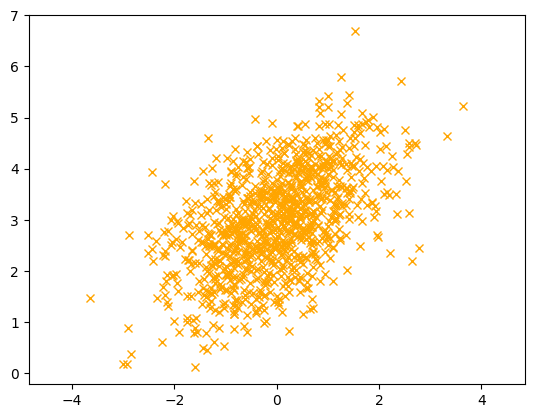

In [35]:
import matplotlib.pyplot as plt
x = negative_samples[:, 0]
y = negative_samples[:, 1]
plt.plot(x, y, 'x', color='orange')
plt.axis('equal')
plt.show()

We create the targets as well

In [41]:
negative_targets = np.zeros((num_samples_per_class, 1), dtype='float32')

In [39]:
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples.shape

(1000, 2)

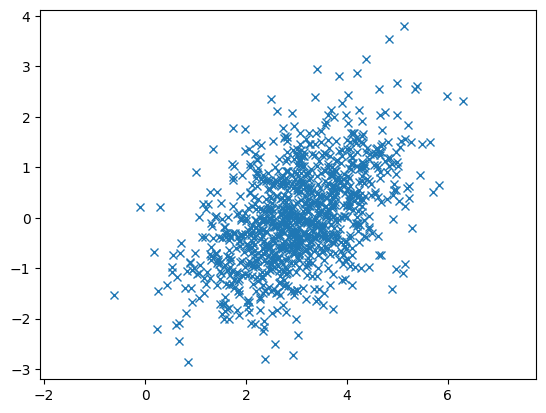

In [37]:
x = positive_samples[:, 0]
y = positive_samples[:, 1]
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()


In [42]:
positive_targets = np.zeros((num_samples_per_class, 1), dtype='float32')

We stack the two 2D datasets into a single 2D array

In [44]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = targets = np.vstack((negative_targets, positive_targets)).astype(np.float32)
inputs.shape, targets.shape

((2000, 2), (2000, 1))

## Model compilation
Once the loss function, the optimizer, and the metric have been chosen we can call the compile() method to connect these components to the network and start the training procedure.  

In [45]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

## Model fit
After the network topology is defined and the loss function with the optimization method and the performance metrics have been selected for the task at hand we have to tell provide the dataset to use for the training with the set of examples, i.e. inputs and target values, the size of the batch to use for each parameters update, and the number of epochs, that is, the number of times the full dataset has to be used for the training.

In [46]:
history = model.fit(
  inputs,
  targets,
  epochs=5,
  batch_size=128
)


Epoch 1/5
16/16 [==============================] - 1s 2ms/step - loss: 3.1153 - binary_accuracy: 0.5005
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 2.9058 - binary_accuracy: 0.5015
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 2.7309 - binary_accuracy: 0.5015
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 2.5658 - binary_accuracy: 0.5020
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 2.4058 - binary_accuracy: 0.5020


In [49]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 16}

We create a simple model of one layer, then we set the loss function, the optimizer, and the performance metrics

In [50]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
loss=keras.losses.MeanSquaredError(),
metrics=[keras.metrics.BinaryAccuracy()])

Our model is ready for training. Before we start we shuffle the dataset

In [52]:
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

## Training and validation set
We split the dataset into a training set and a validation set

In [53]:
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

We fit the model using the training set. The validation set is used to track the performance of the network during the training  

In [54]:
model.fit(
  training_inputs,
  training_targets,
  epochs=5,
  batch_size=16,
  validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 9ms/step - loss: 0.1507 - binary_accuracy: 0.9600 - val_loss: 3.0285e-04 - val_binary_accuracy: 1.0000
Epoch 2/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0436 - binary_accuracy: 0.9850 - val_loss: 1.4429e-06 - val_binary_accuracy: 1.0000
Epoch 3/5
88/88 [==============================] - 0s 4ms/step - loss: 0.0469 - binary_accuracy: 0.9679 - val_loss: 1.7664e-04 - val_binary_accuracy: 1.0000
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0459 - binary_accuracy: 0.9714 - val_loss: 0.0126 - val_binary_accuracy: 1.0000
Epoch 5/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0518 - binary_accuracy: 0.9729 - val_loss: 0.0361 - val_binary_accuracy: 1.0000


In [55]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 4ms/step - loss: 0.0361 - binary_accuracy: 1.0000


## Inference
Once the model is trained it can be used for inference. For instance we can make predictions using the validation set

In [56]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 3ms/step
[[-0.11680844]
 [-0.2179299 ]
 [-0.21180232]
 [-0.27385187]
 [-0.13171664]
 [-0.21666421]
 [-0.20281276]
 [-0.37584326]
 [-0.08811986]
 [-0.15790421]]
